                  Date    EUA Market_size    Oil    Coal      NG  Power    IR  \
2014-12-29  2014-12-29   7.25      1160.0  57.88    67.2  21.673  34.82  0.05   
2014-12-30  2014-12-30   7.21      1514.1   57.9    66.8  21.208  34.82  0.05   
2014-12-31  2014-12-31   7.25         0.0  57.33    66.7  21.296  34.82  0.05   
2015-01-01  2015-01-01   7.25         0.0  57.33    66.7  21.296   32.1  0.05   
2015-01-02  2015-01-02   7.01       280.4  56.42   65.55  20.448   32.1  0.05   
...                ...    ...         ...    ...     ...     ...    ...   ...   
2024-10-23  2024-10-23  64.89   1979145.0  74.96   119.1   41.38  75.99   3.4   
2024-10-24  2024-10-24  66.63   2794462.2  74.38  119.25  42.154  75.99   3.4   
2024-10-25  2024-10-25  66.97   2096830.7  76.05  119.59  43.513  75.99   3.4   
2024-10-26  2024-10-26  66.97   2096830.7  76.05  119.59  43.513  75.99   3.4   
2024-10-27  2024-10-26  66.97   2096830.7  76.05  119.59  43.513  75.99   3.4   

                    GDP    

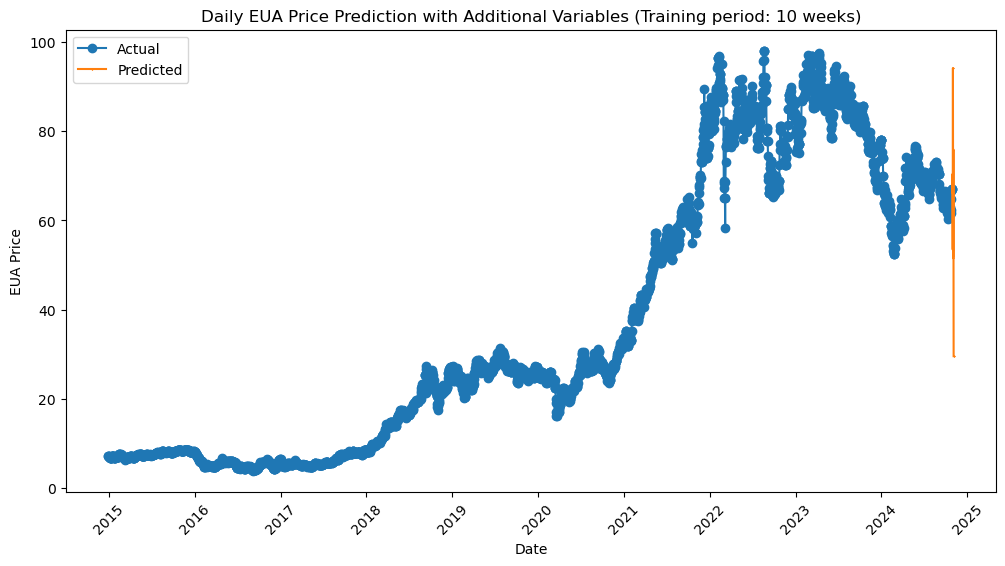

In [1]:
#@@최종@@, 10월28일~11월03일 예측
!pip install xgboost

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 데이터 불러오기
df = pd.read_csv('NEW_EUA.csv')

# 날짜 형식으로 변환
df['DATE'] = pd.to_datetime(df['Date'])
df.set_index('DATE', inplace=True)
df.sort_index(inplace=True)

# 날짜 범위 설정
start_date = '2014-12-29'
end_date = '2024-10-27'

# 지정한 날짜 간격으로 데이터 필터링
filtered_data = df[(df.index >= start_date) & (df.index <= end_date)]
# 27일 값 추가하기
last_row = filtered_data.iloc[-1]  # 마지막 행 복사
last_row_df = pd.DataFrame(last_row).T # 마지막 행을 데이터프레임으로 변환
last_row_df.index = [filtered_data.index[-1] + pd.Timedelta(days=1)]  # 인덱스 재설정 (기존 인덱스와 충돌 방지) # 다음 날로 설정
filtered_data = pd.concat([filtered_data, last_row_df]) # 마지막 행 추가 (pd.concat 사용)
print(filtered_data)




# 일 단위로 데이터 사용 (EUA 및 추가 변수들)
feature_columns = ['EUA', 'Market_size', 'Oil', 'Coal', 'NG', 'Power', 
                   'IR', 'USEU', 'S&P_clean', 'DAX']
daily_data = filtered_data[feature_columns].dropna()

# 훈련 기간 설정 (주 수로)
training_period_weeks = 10  # 10주 훈련 기간
training_period_days = training_period_weeks * 7  # 일 수로 변환

print(f"\n훈련 기간: {training_period_weeks}주 ({training_period_days}일)")

# X와 y 데이터 생성 (훈련 기간을 고려)
X, y = [], []
for i in range(len(daily_data) - training_period_days):  # 지정된 훈련 기간까지 예측
    X.append(daily_data.iloc[i:i + training_period_days].values.flatten())  # 훈련 기간의 데이터를 평면화
    y.append(daily_data.iloc[i + training_period_days]['EUA'])  # 훈련 기간 후의 EUA 데이터
X = np.array(X)
y = np.array(y)

# 훈련 및 테스트 데이터 분리
if X.shape[0] > 0 and y.shape[0] > 0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

    # XGBoost 모델 학습
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
    model.fit(X_train, y_train)

    # 마지막 날 예측
    last_day_data = daily_data.iloc[-training_period_days:].values.flatten().reshape(1, -1)  # 마지막 훈련 기간 데이터
    last_week_average = []
    
    # 마지막 주 평균 예측
    for _ in range(7):  # 7일 예측
        predicted_next_day = model.predict(last_day_data)  # 다음 날 예측
        last_week_average.append(predicted_next_day)  # 예측된 값 추가
        # 다음 입력으로 사용할 데이터 준비
        last_day_data = np.roll(last_day_data, -1)  # 마지막 데이터를 앞으로 이동
        last_day_data[0, -1] = predicted_next_day[0]  # 새로 예측된 값 추가

    # 평균 계산
    last_week_avg = np.mean(last_week_average)

    # 최종 예측값 및 날짜 출력
    end_date = pd.to_datetime(end_date)
    last_pred_start_date = end_date + pd.Timedelta(days=1)  # 마지막 예측 시작 날짜
    last_pred_end_date = last_pred_start_date + pd.Timedelta(days=6)  # 마지막 예측 종료 날짜
    print(f"최종 예측 기간: {last_pred_start_date.strftime('%Y년 %m월 %d일')} 부터 "
          f"{last_pred_end_date.strftime('%Y년 %m월 %d일')} 까지, "
          f"예측된 마지막 주 평균 EUA 가격: {last_week_avg:.2f}")

    # 예측 결과 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(daily_data.index, daily_data['EUA'], label='Actual', marker='o')

    # 마지막 주의 예측 결과 시각화
    pred_dates = [last_pred_start_date + pd.Timedelta(days=i) for i in range(7)]
    plt.plot(pred_dates, last_week_average, label='Predicted', marker='x',markersize=1)

    plt.title(f"Daily EUA Price Prediction with Additional Variables (Training period: {training_period_weeks} weeks)")
    plt.xlabel("Date")
    plt.ylabel("EUA Price")
    plt.xticks(rotation=45)
    plt.legend()
    #plt.savefig(f'daily_prediction_plot_with_additional_variables_training_period_{training_period_weeks}_weeks.jpg', dpi=400)  # 파일 저장
    plt.show()
else:
    print("No valid data available for training and testing.")
